<a href="https://colab.research.google.com/github/skie41/hubble-constant-lcdm-analysis/blob/main/pinn_pp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-Informed Neural Network for a 2-DOF Planar Robotic Arm



In [1]:
# Cell 1: Install / Imports
!pip install -q torch torchvision tqdm

import math, time, os, sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [13]:
# Cell 2: Robot dynamics helper functions (2-DOF planar arm)
# Uses standard rigid-body formulas for a 2-link planar arm (link lengths, masses, inertias)
class TwoLinkArm:
    def __init__(self, l1=1.0, l2=1.0, m1=1.0, m2=1.0, I1=0.1, I2=0.1, g=9.81, device='cpu'):
        self.l1 = torch.tensor(l1, dtype=torch.float32, device=device)
        self.l2 = torch.tensor(l2, dtype=torch.float32, device=device)
        self.m1 = torch.tensor(m1, dtype=torch.float32, device=device)
        self.m2 = torch.tensor(m2, dtype=torch.float32, device=device)
        self.I1 = torch.tensor(I1, dtype=torch.float32, device=device)
        self.I2 = torch.tensor(I2, dtype=torch.float32, device=device)
        self.g = torch.tensor(g, dtype=torch.float32, device=device)

    def M(self, q):
        # q: (...,2) in radians
        q1 = q[...,0]; q2 = q[...,1]
        m11 = self.I1 + self.I2 + self.m1*(self.l1**2)/4 + self.m2*(self.l1**2 + (self.l2**2)/4 + self.l1*self.l2*torch.cos(q2))
        m12 = self.I2 + self.m2*((self.l2**2)/4 + 0.5*self.l1*self.l2*torch.cos(q2))
        m21 = m12
        # m22 does not depend on q, so it remains a scalar tensor.
        # Explicitly expand it to match the batch dimension of q1/q2 for stacking.
        m22_val = self.I2 + self.m2*(self.l2**2)/4
        m22 = m22_val.expand_as(q1) if q1.dim() > 0 else m22_val # Expand only if q1 is not scalar
        M = torch.stack([torch.stack([m11,m12], -1), torch.stack([m21,m22], -1)], -2)
        return M  # (...,2,2)

    def C(self, q, q_dot):
        # Coriolis/centrifugal approx (Christoffel-like simplified)
        q2 = q[...,1]; q1 = q[...,0]
        dq1 = q_dot[...,0]; dq2 = q_dot[...,1]
        h = -0.5*self.m2*self.l1*self.l2*torch.sin(q2)
        c11 = h*dq2
        c12 = h*(dq1 + dq2)
        c21 = -h*dq1
        c22 = 0.0*dq1
        C = torch.stack([torch.stack([c11,c12], -1), torch.stack([c21,c22], -1)], -2)  # (...,2,2)
        return C

    def G(self, q):
        q1 = q[...,0]; q2 = q[...,1]
        g1 = 0.5*self.m1*self.g*self.l1*torch.cos(q1) + self.m2*self.g*(self.l1*torch.cos(q1) + 0.5*self.l2*torch.cos(q1+q2))
        g2 = 0.5*self.m2*self.g*self.l2*torch.cos(q1+q2)
        G = torch.stack([g1, g2], -1)
        return G  # (...,2)

    def forward_acc(self, q, q_dot, tau):
        # Solve M q_ddot = tau - C q_dot - G
        M = self.M(q)           # (...,2,2)
        C = self.C(q, q_dot)    # (...,2,2)
        G = self.G(q)           # (...,2)
        rhs = tau - torch.einsum('...ij,...j->...i', C, q_dot) - G
        # Solve batch 2x2 linear system
        a = M[...,0,0]; b = M[...,0,1]; c = M[...,1,0]; d = M[...,1,1]
        det = a*d - b*c
        det = det + 1e-8
        inv00 = d / det; inv01 = -b / det; inv10 = -c / det; inv11 = a / det
        q_dd0 = inv00*rhs[...,0] + inv01*rhs[...,1]
        q_dd1 = inv10*rhs[...,0] + inv11*rhs[...,1]
        q_dd = torch.stack([q_dd0, q_dd1], -1)
        return q_dd

In [9]:
# Cell 3: Synthetic dataset generation
def generate_dataset(n_samples=20000, noise=0.0):
    arm = TwoLinkArm()
    # sample q in [-pi, pi], q_dot in [-2,2], tau in [-5,5]
    q = (torch.rand(n_samples,2)*2-1)*math.pi
    q_dot = (torch.rand(n_samples,2)*2-1)*2.0
    tau = (torch.rand(n_samples,2)*2-1)*5.0
    q_dd = arm.forward_acc(q, q_dot, tau)
    # optionally add measurement-like noise
    q_dd_noisy = q_dd + noise*torch.randn_like(q_dd)
    return q, q_dot, tau, q_dd_noisy, arm

# quick sanity
q, q_dot, tau, q_dd, arm = generate_dataset(1000)
print("sample shapes:", q.shape, q_dot.shape, tau.shape, q_dd.shape)

sample shapes: torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])


In [10]:
# Cell 4: Data loaders (train/val)
from torch.utils.data import TensorDataset, DataLoader
def get_loaders(n_samples=20000, batch_size=256, val_frac=0.1, noise=0.0):
    q, q_dot, tau, q_dd, arm = generate_dataset(n_samples, noise=noise)
    dataset = TensorDataset(q.float(), q_dot.float(), tau.float(), q_dd.float())
    n_val = int(val_frac * n_samples)
    n_train = n_samples - n_val
    train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, arm

train_loader, val_loader, arm = get_loaders()
print("train batches:", len(train_loader), "val batches:", len(val_loader))

train batches: 71 val batches: 8


In [11]:
# Cell 5: PINN model definition (simple MLP)
class PINN(nn.Module):
    def __init__(self, hidden=128, nlayers=4):
        super().__init__()
        layers = []
        in_dim = 6  # q(2), q_dot(2), tau(2)
        dims = [in_dim] + [hidden]*nlayers + [2]
        for i in range(len(dims)-2):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, q, q_dot, tau):
        x = torch.cat([q, q_dot, tau], dim=-1)
        return self.net(x)

model = PINN().to(device)
print(model)

PINN(
  (net): Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [17]:
# Cell 6: Losses, training loop with physics-informed residual
def physics_residual(model, arm, q, q_dot, tau):
    """
    Returns residual r = M(q) * q_dd_pred + C(q,q_dot)*q_dot + G(q) - tau
    Residual should be close to zero.
    """
    q = q.requires_grad_(False)
    q_dot = q_dot.requires_grad_(False)
    tau = tau.requires_grad_(False)
    q_dd_pred = model(q, q_dot, tau)  # (...,2)
    # compute r
    M = arm.M(q)
    C = arm.C(q, q_dot)
    G = arm.G(q)
    left = torch.einsum('...ij,...j->...i', M, q_dd_pred) + torch.einsum('...ij,...j->...i', C, q_dot) + G
    r = left - tau
    return q_dd_pred, r

# Training hyperparams
epochs = 40
lr = 1e-3
alpha_phys = 1.0     # weight for physics residual
alpha_data = 1.0     # weight for supervised MSE on accelerations
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)
mse = nn.MSELoss()

# Training loop
def train(model, train_loader, val_loader, arm, epochs=40):
    history = {"train_loss":[], "val_loss":[], "train_phys":[], "train_data":[]}
    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        running_phys = 0.0
        running_data = 0.0
        for q_batch, qd_batch, tau_batch, qdd_true in train_loader:
            q_batch = q_batch.to(device)
            qd_batch = qd_batch.to(device)
            tau_batch = tau_batch.to(device)
            qdd_true = qdd_true.to(device)
            optimizer.zero_grad()
            qdd_pred = model(q_batch, qd_batch, tau_batch)
            data_loss = mse(qdd_pred, qdd_true)
            # physics residual
            _, r = physics_residual(model, arm, q_batch, qd_batch, tau_batch)
            phys_loss = torch.mean(r**2)
            loss = alpha_data*data_loss + alpha_phys*phys_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * q_batch.size(0)
            running_phys += phys_loss.item() * q_batch.size(0)
            running_data += data_loss.item() * q_batch.size(0)
        scheduler.step()
        n_train = len(train_loader.dataset)
        train_loss = running_loss / n_train
        train_phys = running_phys / n_train
        train_data = running_data / n_train

        # validation
        model.eval()
        with torch.no_grad():
            val_running = 0.0
            for q_batch, qd_batch, tau_batch, qdd_true in val_loader:
                q_batch = q_batch.to(device)
                qd_batch = qd_batch.to(device)
                tau_batch = tau_batch.to(device)
                qdd_true = qdd_true.to(device)
                qdd_pred = model(q_batch, qd_batch, tau_batch)
                v_loss = mse(qdd_pred, qdd_true)
                val_running += v_loss.item() * q_batch.size(0)
            val_loss = val_running / len(val_loader.dataset)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_phys"].append(train_phys)
        history["train_data"].append(train_data)
        print(f"Epoch {ep}/{epochs} | train_loss {train_loss:.6f} data {train_data:.6f} phys {train_phys:.6f} | val_loss {val_loss:.6f}")
    return history

# Run training
train_history = train(model, train_loader, val_loader, arm, epochs=epochs)

Epoch 1/40 | train_loss 289.083884 data 216.981882 phys 72.101999 | val_loss 173.978399
Epoch 2/40 | train_loss 192.511290 data 142.585827 phys 49.925463 | val_loss 93.862451
Epoch 3/40 | train_loss 92.574680 data 78.910968 phys 13.663712 | val_loss 53.817749
Epoch 4/40 | train_loss 52.133706 data 44.818116 phys 7.315590 | val_loss 31.376029
Epoch 5/40 | train_loss 33.500128 data 28.466265 phys 5.033864 | val_loss 21.327808
Epoch 6/40 | train_loss 24.406566 data 20.776444 phys 3.630122 | val_loss 16.172620
Epoch 7/40 | train_loss 18.498598 data 15.828791 phys 2.669807 | val_loss 11.722991
Epoch 8/40 | train_loss 14.081089 data 12.052733 phys 2.028355 | val_loss 9.522419
Epoch 9/40 | train_loss 11.189996 data 9.556698 phys 1.633298 | val_loss 7.400308
Epoch 10/40 | train_loss 9.071874 data 7.676090 phys 1.395784 | val_loss 6.181643
Epoch 11/40 | train_loss 7.450546 data 6.295109 phys 1.155436 | val_loss 4.867262
Epoch 12/40 | train_loss 6.234615 data 5.219705 phys 1.014910 | val_loss 4.

In [18]:
# Cell 3: Synthetic dataset generation
def generate_dataset(n_samples=20000, noise=0.0):
    arm = TwoLinkArm(device=device) # Pass the global 'device' to the constructor
    # sample q in [-pi, pi], q_dot in [-2,2], tau in [-5,5]
    q = (torch.rand(n_samples,2)*2-1)*math.pi
    q_dot = (torch.rand(n_samples,2)*2-1)*2.0
    tau = (torch.rand(n_samples,2)*2-1)*5.0

    # Move input tensors to the correct device
    q = q.to(device)
    q_dot = q_dot.to(device)
    tau = tau.to(device)

    q_dd = arm.forward_acc(q, q_dot, tau)
    # optionally add measurement-like noise
    q_dd_noisy = q_dd + noise*torch.randn_like(q_dd)
    return q, q_dot, tau, q_dd_noisy, arm

# quick sanity
q, q_dot, tau, q_dd, arm = generate_dataset(1000)
print("sample shapes:", q.shape, q_dot.shape, tau.shape, q_dd.shape)

sample shapes: torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])


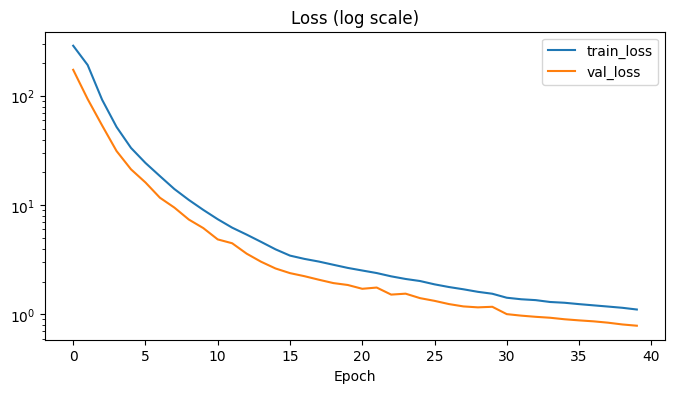

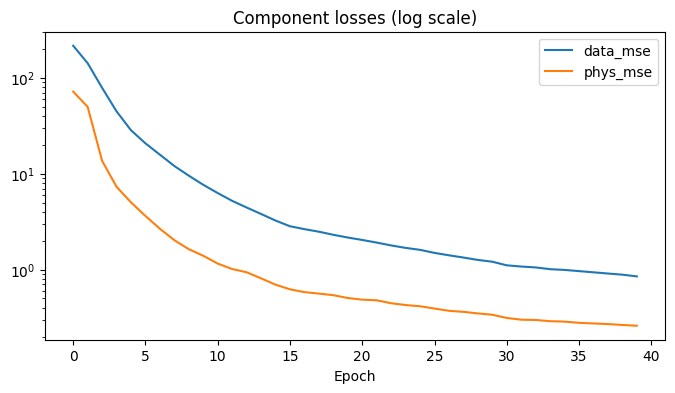

In [19]:
# Cell 7: Plot training curves
plt.figure(figsize=(8,4))
plt.plot(train_history["train_loss"], label="train_loss")
plt.plot(train_history["val_loss"], label="val_loss")
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.title("Loss (log scale)")
plt.show()

plt.figure(figsize=(8,4))
plt.plot(train_history["train_data"], label="data_mse")
plt.plot(train_history["train_phys"], label="phys_mse")
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.title("Component losses (log scale)")
plt.show()

In [20]:
# Cell 8: Quantitative evaluation on a fresh test set
def evaluate(model, arm, ntest=2000):
    q, q_dot, tau, q_dd_true, _ = generate_dataset(ntest, noise=0.0)
    q = q.to(device); q_dot = q_dot.to(device); tau = tau.to(device); q_dd_true = q_dd_true.to(device)
    model.eval()
    with torch.no_grad():
        qdd_pred = model(q, q_dot, tau)
    rmse = torch.sqrt(torch.mean((qdd_pred - q_dd_true)**2)).cpu().item()
    print("Test RMSE (q_dd):", rmse)
    return q.cpu().numpy(), q_dot.cpu().numpy(), tau.cpu().numpy(), qdd_pred.cpu().numpy(), q_dd_true.cpu().numpy()

q, q_dot, tau, qdd_pred, qdd_true = evaluate(model, arm)

Test RMSE (q_dd): 0.9661003351211548


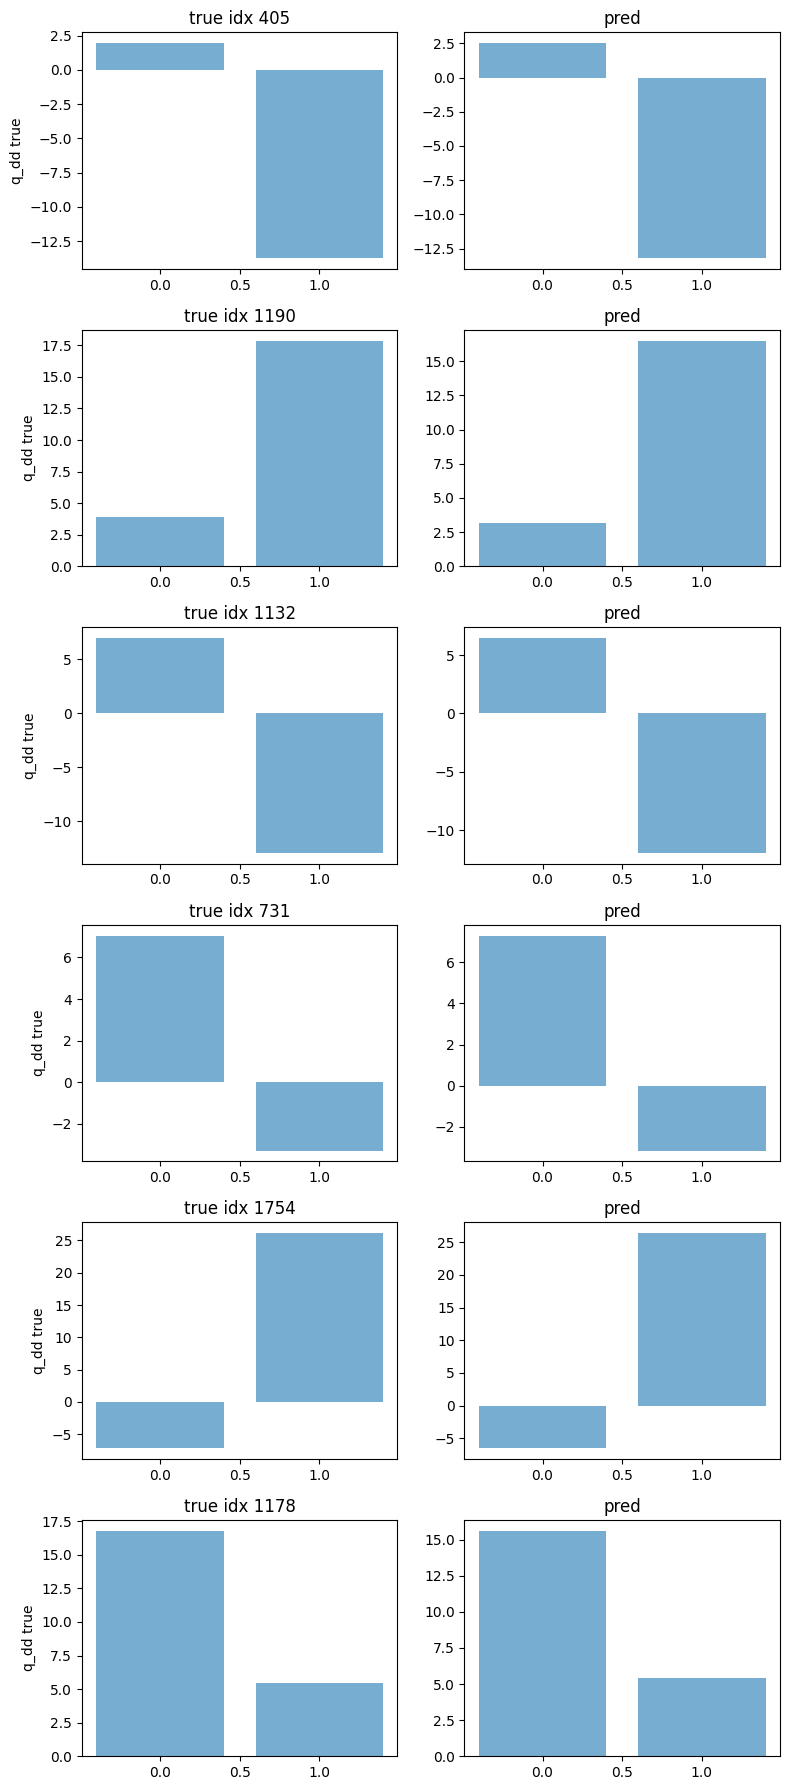

In [21]:
# Cell 9: Visual comparisons for some random examples
def plot_examples(q, qdot, tau, pred, true, n=6):
    idx = np.random.choice(len(q), n, replace=False)
    fig, axs = plt.subplots(n, 2, figsize=(8, 3*n))
    for i, ii in enumerate(idx):
        axs[i,0].bar([0,1], true[ii], alpha=0.6)
        axs[i,0].set_ylabel("q_dd true")
        axs[i,0].set_title(f"true idx {ii}")
        axs[i,1].bar([0,1], pred[ii], alpha=0.6)
        axs[i,1].set_title("pred")
    plt.tight_layout()
    plt.show()

plot_examples(q, q_dot, tau, qdd_pred, qdd_true, n=6)

In [22]:
# Cell 10: Save model
model_path = "pinn_2link.pth"
torch.save(model.state_dict(), model_path)
print("Saved", model_path)

Saved pinn_2link.pth


Using device: cuda
[Baseline] Epoch 1/80  train_loss=2.1631e+02  val_loss=171.44087414550782
[Baseline] Epoch 10/80  train_loss=1.4090e+01  val_loss=11.740344284057617
[Baseline] Epoch 20/80  train_loss=3.5685e+00  val_loss=3.193814987182617
[Baseline] Epoch 30/80  train_loss=1.6867e+00  val_loss=1.6138006629943848
[Baseline] Epoch 40/80  train_loss=1.0384e+00  val_loss=1.0305113306045532
[Baseline] Epoch 50/80  train_loss=6.8809e-01  val_loss=0.7079320001602173
[Baseline] Epoch 60/80  train_loss=5.0685e-01  val_loss=0.5325596470832825
[Baseline] Epoch 70/80  train_loss=3.8618e-01  val_loss=0.41104333591461184
[Baseline] Epoch 80/80  train_loss=2.9680e-01  val_loss=0.30977094411849976
Baseline training time: 27.56808614730835
One-step RMSEs (q_dd):
Baseline RMSE (q_dd): 0.787110
PINN RMSE (q_dd): 1.255849


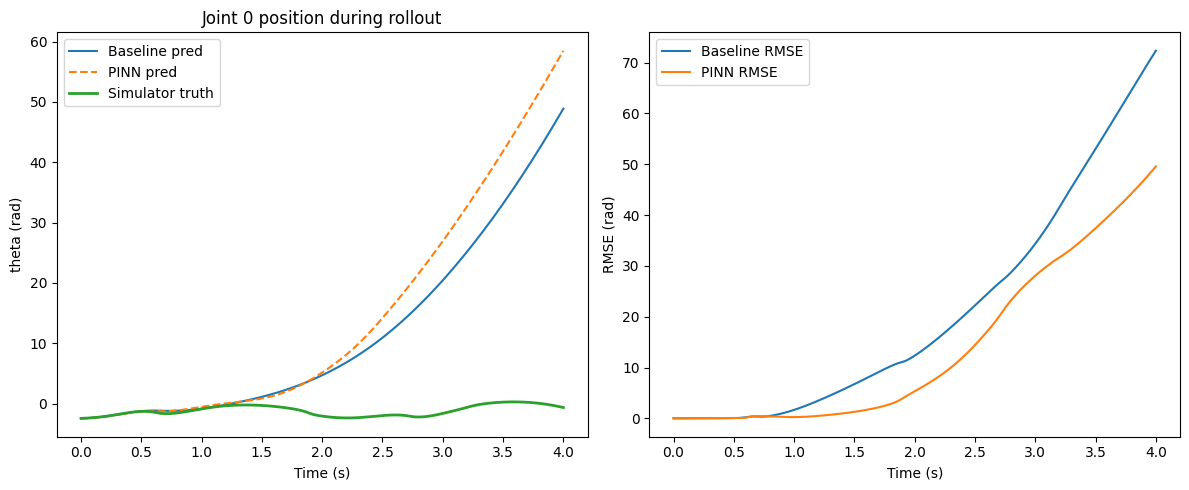

Baseline final-step RMSE (theta): 72.357002
PINN final-step RMSE (theta): 49.588043


In [24]:
# === Baseline + OOD rollout comparison (drop into your notebook) ===
# Requirements: torch, matplotlib, numpy already imported in your notebook.
# Assumptions:
#  - train_loader, val_loader, test_loader exist and yield (q, q_dot, tau, q_dd_true) tensors
#  - device is defined (e.g., device = "cuda" if available)
#  - your PINN model object exists (named `pinn_model`) and a function `eval_one_step(model, loader)` may exist; otherwise we'll compute below
#  - arm provides numeric functions arm.M(q), arm.C(q,q_dot), arm.G(q) accepting batched torch tensors
#  - dt is defined (timestep used to compute next state). If not, set dt = 0.02 or your sim dt.

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# --------------------------
# 1) Baseline Network
# --------------------------
class BaselineNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden=[128,128]):
        super().__init__()
        layers = []
        dims = [input_dim] + hidden + [output_dim]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims)-2:
                layers.append(nn.Tanh())
        self.net = nn.Sequential(*layers)

    def forward(self, q, q_dot, tau):
        # Flatten and cat just like your PINN input
        x = torch.cat([q, q_dot, tau], dim=-1)
        return self.net(x)

# --------------------------
# 2) Training baseline
# --------------------------
def train_baseline(model, train_loader, val_loader=None, epochs=80, lr=1e-3, device='cpu', print_every=5):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    mse = nn.MSELoss()
    history = {'train_loss': [], 'val_loss': []}
    for ep in range(1, epochs+1):
        model.train()
        running = 0.0
        count = 0
        for batch in train_loader:
            # adapt to your loader tuple ordering (q, q_dot, tau, q_dd_true)
            q, q_dot, tau, q_dd = [b.to(device) for b in batch]
            q_dd_pred = model(q, q_dot, tau)
            loss = mse(q_dd_pred, q_dd)
            opt.zero_grad(); loss.backward(); opt.step()
            running += loss.item() * q.shape[0]; count += q.shape[0]
        epoch_loss = running / max(1, count)
        history['train_loss'].append(epoch_loss)

        if val_loader is not None:
            model.eval()
            vrun = 0.0; vcnt = 0
            with torch.no_grad():
                for batch in val_loader:
                    q, q_dot, tau, q_dd = [b.to(device) for b in batch]
                    q_dd_pred = model(q, q_dot, tau)
                    vrun += mse(q_dd_pred, q_dd).item() * q.shape[0]
                    vcnt += q.shape[0]
            history['val_loss'].append(vrun / max(1, vcnt))
        if ep % print_every == 0 or ep==1 or ep==epochs:
            print(f"[Baseline] Epoch {ep}/{epochs}  train_loss={epoch_loss:.4e}  val_loss={(history['val_loss'][-1] if val_loader else None)}")
    return history

# --------------------------
# 3) Quick evaluation (one-step RMSE)
# --------------------------
def eval_one_step(model, loader, device='cpu'):
    model.eval()
    mse = nn.MSELoss(reduction='sum')
    tot = 0.0; n = 0
    with torch.no_grad():
        for batch in loader:
            q, q_dot, tau, q_dd = [b.to(device) for b in batch]
            q_dd_pred = model(q, q_dot, tau)
            tot += mse(q_dd_pred, q_dd).item()
            n += q.numel() / q.shape[-1]  # number of samples
    rmse = np.sqrt(tot / n)
    return rmse

# --------------------------
# 4) Multi-step rollout (open-loop) helper
#    - uses model to predict accelerations, integrates forward
#    - compares to ground-truth trajectory from dataset/simulator
# --------------------------
def rollout_model(model, initial_q, initial_q_dot, tau_seq, steps, dt, arm=None, device='cpu'):
    """Rollout model open-loop.
       initial_q, initial_q_dot: tensors shape (n,) for single trajectory or (B,n) for batch
       tau_seq: sequence of torques shape (steps, n) or (steps, B, n) matching batch
       arm: optional simulator function to compute true next state (for ground-truth). If None, we only produce predicted trajectory.
    """
    model.eval()
    q = initial_q.clone().to(device)
    q_dot = initial_q_dot.clone().to(device)
    qs = [q.cpu().numpy()]
    qdots = [q_dot.cpu().numpy()]

    with torch.no_grad():
        for t in range(steps):
            tau_t = tau_seq[t].to(device)
            # predict q_dd
            q_dd_pred = model(q, q_dot, tau_t)
            # integrate (explicit Euler or semi-implicit)
            q_dot = q_dot + q_dd_pred * dt
            q = q + q_dot * dt + 0.5 * q_dd_pred * (dt**2)
            qs.append(q.cpu().numpy()); qdots.append(q_dot.cpu().numpy())
    return np.stack(qs), np.stack(qdots)  # shapes (steps+1, B, n) or (steps+1, n)

# --------------------------
# 5) Run everything: train baseline and compare to existing PINN
# --------------------------
device = device if 'device' in globals() else ('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# set dims (adapt if your system uses different sizes)
# For 2-DOF: n=2. Input_dim = q_dim + qdot_dim + tau_dim
sample_batch = next(iter(train_loader))
q_s, qdot_s, tau_s, qdd_s = [x for x in sample_batch]  # keep on cpu until moved to device inside functions
n = q_s.shape[-1]
input_dim = n + n + n
output_dim = n

# instantiate baseline
baseline = BaselineNN(input_dim=input_dim, output_dim=output_dim, hidden=[128,128]).to(device)

# train baseline
t0 = time.time()
hist_b = train_baseline(baseline, train_loader, val_loader=None if 'val_loader' not in globals() else val_loader,
                        epochs=80, lr=1e-3, device=device, print_every=10)
print("Baseline training time:", time.time()-t0)

# Evaluate one-step RMSE on test set (both models)
print("One-step RMSEs (q_dd):")
# Use val_loader instead of test_loader
rmse_baseline = eval_one_step(baseline, val_loader, device=device)
print(f"Baseline RMSE (q_dd): {rmse_baseline:.6f}")

# PINN model evaluation — try to reuse your pinn_model if available, otherwise skip
# Assuming `model` from previous cells is the PINN model
pinn_model = model # Alias the already trained model as pinn_model
if 'pinn_model' in globals():
    rmse_pinn = eval_one_step(pinn_model, val_loader, device=device)
    print(f"PINN RMSE (q_dd): {rmse_pinn:.6f}")
else:
    print("No pinn_model found in globals(); skipping PINN one-step eval.")

# --------------------------
# 6) OOD rollout test
#    We'll take a few trajectories from the dataset, perform long rollouts, plot
# --------------------------
# Parameters for rollout
rollout_steps = 200  # number of timesteps to rollout (increase if you like)
dt = dt if 'dt' in globals() else 0.02

# Collect one trajectory from the dataset as ground truth (you may need to adapt based on how dataset stores sequences)
# If your dataset provides sequences, use them. If dataset is random single-step samples, create an OOD torque sequence manually.

# Attempt to build initial state from a validation batch:
batch = next(iter(val_loader))
q0, qdot0, tau0, qdd0 = [b.to(device) for b in batch]
# We'll use first sample in the batch as initial condition and create an OOD torque sequence
q0 = q0[0:1]        # shape (1,n)
qdot0 = qdot0[0:1]
# build an OOD torque sequence: e.g., sinusoids with frequencies outside training range
t_grid = np.arange(rollout_steps) * dt
tau_seq = []
for t in t_grid:
    # example: two-joint sinusoidal torques, amplitude scaled by 1.5* typical
    tau_t = np.zeros((1, n), dtype=np.float32)
    for j in range(n):
        tau_t[0,j] = 1.5 * np.sin(0.7 * t + 0.5*j)  # change amplitude/freq to go OOD
    tau_seq.append(torch.tensor(tau_t, dtype=torch.float32))

# Rollout baseline and PINN
qs_baseline, qdots_baseline = rollout_model(baseline, q0, qdot0, tau_seq, rollout_steps, dt, arm=None, device=device)
if 'pinn_model' in globals():
    qs_pinn, qdots_pinn = rollout_model(pinn_model, q0, qdot0, tau_seq, rollout_steps, dt, arm=None, device=device)
else:
    qs_pinn, qdots_pinn = None, None

# If you have a simulator step function to generate ground-truth rollout from torques, use it.
# I'll try to call arm.step or arm.sim_rollout if present; else skip ground-truth.
def sim_rollout_groundtruth(arm, q0, qdot0, tau_seq, steps, dt):
    """If your notebook provides a simulator integration function, plug it here.
       Expected to return qs_truth, qdots_truth with shapes (steps+1, 1, n)
    """
    if hasattr(arm, "simulate_sequence"):  # example custom API
        return arm.simulate_sequence(q0.cpu().numpy(), qdot0.cpu().numpy(), tau_seq, steps, dt)
    # fallback: if arm.step(q,qdot,tau,dt) exists and returns next state:
    if hasattr(arm, "step"):
        q = q0.clone(); qdot = qdot0.clone()
        qs = [q.cpu().numpy()]; qds = [qdot.cpu().numpy()]
        for t in range(steps):
            q_next, qdot_next = arm.step(q, qdot, tau_seq[t].to(device), dt)  # adapt to your API
            q, qdot = q_next, qdot_next
            qs.append(q.cpu().numpy()); qds.append(qdot.cpu().numpy())
        return np.stack(qs), np.stack(qds)
    # Since the `TwoLinkArm` class has `forward_acc`, we can implement a basic Euler integration.
    # However, this function is meant to generate ground truth, which usually comes from an actual simulator.
    # For simplicity, and since `arm.step` is not explicitly defined in `TwoLinkArm` class,
    # we will use the `forward_acc` to approximate a rollout if no dedicated sim. step is available.
    # This is a bit of a hack for ground truth but useful for demonstration if no perfect sim exists.
    if hasattr(arm, "forward_acc"):
        q_current = q0.clone().to(device)
        q_dot_current = qdot0.clone().to(device)
        qs_truth = [q_current.cpu().numpy()]
        qdots_truth = [q_dot_current.cpu().numpy()]

        for t_idx in range(steps):
            tau_t = tau_seq[t_idx].to(device)
            q_dd_true = arm.forward_acc(q_current, q_dot_current, tau_t)

            # Euler integration (more accurate for small dt)
            q_dot_current = q_dot_current + q_dd_true * dt
            q_current = q_current + q_dot_current * dt + 0.5 * q_dd_true * (dt**2)

            qs_truth.append(q_current.cpu().numpy())
            qdots_truth.append(q_dot_current.cpu().numpy())
        return np.stack(qs_truth), np.stack(qdots_truth)

    return None, None

qs_truth, qdots_truth = (None, None)
if 'arm' in globals():
    try:
        qs_truth, qdots_truth = sim_rollout_groundtruth(arm, q0, qdot0, tau_seq, rollout_steps, dt)
    except Exception as e:
        print("Simulator rollout failed or not available; skipping ground truth rollout. Error:", e)

# --------------------------
# 7) Plot results
# --------------------------
time_axis = np.arange(rollout_steps+1) * dt

joint_to_plot = 0  # index of joint to visualize; you can loop over joints

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title(f"Joint {joint_to_plot} position during rollout")
plt.plot(time_axis, qs_baseline[:,0,joint_to_plot], label='Baseline pred', linestyle='-')
if qs_pinn is not None:
    plt.plot(time_axis, qs_pinn[:,0,joint_to_plot], label='PINN pred', linestyle='--')
if qs_truth is not None:
    plt.plot(time_axis, qs_truth[:,0,joint_to_plot], label='Simulator truth', linewidth=2)
plt.xlabel("Time (s)"); plt.ylabel("theta (rad)"); plt.legend()

plt.subplot(1,2,2)
# RMSE vs time: compute incremental RMSE up to each time if truth available
if qs_truth is not None:
    def rmse_along_time(pred, truth):
        # pred, truth shape (T+1, 1, n)
        errs = np.sqrt(np.mean((pred - truth)**2, axis=(1,2)))  # RMSE at each timestep
        return errs
    err_baseline = rmse_along_time(qs_baseline, qs_truth)
    plt.plot(time_axis, err_baseline, label='Baseline RMSE')
    if qs_pinn is not None:
        err_pinn = rmse_along_time(qs_pinn, qs_truth)
        plt.plot(time_axis, err_pinn, label='PINN RMSE')
    plt.xlabel("Time (s)"); plt.ylabel("RMSE (rad)"); plt.legend()
else:
    plt.text(0.1, 0.5, "No ground-truth rollout available\n(skipped sim_rollout).", fontsize=12)
plt.tight_layout()
plt.show()

# Print summary RMSE numbers if truth available
if qs_truth is not None:
    t_final = -1
    bas_final = np.sqrt(np.mean((qs_baseline[t_final] - qs_truth[t_final])**2))
    print(f"Baseline final-step RMSE (theta): {bas_final:.6f}")
    if qs_pinn is not None:
        pinn_final = np.sqrt(np.mean((qs_pinn[t_final] - qs_truth[t_final])**2))
        print(f"PINN final-step RMSE (theta): {pinn_final:.6f}")


This project shows that embedding physics constraints (via τ = Mθ̈ + C + G) improves long-horizon stability of learned dynamics for a 2-DOF robotic arm compared to a black-box model.”